In [103]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv

import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
# from torchvision import utils, datasets, transforms

import time
import scipy
import sys
import os
import shutil
import random

In [104]:
faces_dir_original = './datasets/att_faces'
faces_count = 40
H = 112
W = 92
train_ratio = 0.6

In [105]:
class Eigenfaces(object):                                                       # *** COMMENTS ***
    faces_count = 40

    faces_dir = '.'                                                             # directory path to the AT&T faces

    train_faces_count = 6                                                       # number of faces used for training
    test_faces_count = 4                                                       # number of faces used for testing

    l = train_faces_count * faces_count                                         # training images count
    m = 92                                                                      # number of columns of the image
    n = 112                                                                     # number of rows of the image
    mn = m * n                                                                  # length of the column vector

    """
    Initializing the Eigenfaces model.
    """

    def __init__(self,_faces_dir = '.'):
        print('> Initializing started')

        self.faces_dir = _faces_dir
        self.energy = 0.85
        self.training_ids = []                                                  # train image id's for every at&t face

        L = np.empty(shape=(self.mn, self.l), dtype='float64')                  # each row of L represents one train image

        cur_img = 0
        for face_id in range(1, self.faces_count + 1):

            training_ids = random.sample(range(1, 11), self.train_faces_count)  # the id's of the 6 random training images
            self.training_ids.append(training_ids)                              # remembering the training id's for later

            for training_id in training_ids:
                path_to_img = os.path.join(self.faces_dir,
                        's' + str(face_id), str(training_id) + '.npy')          # relative path
                # print '> reading file: ' + path_to_img
                img = np.load(path_to_img)
                # img = cv2.imread(path_to_img, 0) # read a grayscale image
                img_col = np.array(img, dtype='float64').flatten()              # flatten the 2d image into 1d

                L[:, cur_img] = img_col[:]                                      # set the cur_img-th column to the current training image
                cur_img += 1
        print(f"L.shape = {L.shape}")
        self.L = L
    def get_evaluate_set(self):
        test_set = np.empty(shape=(self.mn, self.test_faces_count*faces_count), dtype='float64')                  # each row of L represents one train image
        labels = np.empty(shape=(self.test_faces_count*faces_count), dtype='int64')                  # each row of L represents one train image
        cur_img = 0
        for face_id in range(1, self.faces_count + 1):
            for test_id in range(1, 11):
                if (test_id in self.training_ids[face_id-1]) == False:          # we skip the image if it is part of the training set
                    path_to_img = os.path.join(self.faces_dir,
                            's' + str(face_id), str(test_id) + '.npy')          # relative path
                    img = np.load(path_to_img)
                    img_col = np.array(img, dtype='float64').flatten()              # flatten the 2d image into 1d
                    test_set[:, cur_img] = img_col[:]                                      # set the cur_img-th column to the current training image
                    labels[cur_img] = face_id
                    cur_img += 1
        print(f"L.shape = {test_set.shape}")
        self.test_set = test_set
        self.labels = labels
        return test_set, labels


In [106]:
eigenface = Eigenfaces(faces_dir_original)

> Initializing started
L.shape = (10304, 240)


In [107]:
print(eigenface.L.shape)

(10304, 240)


In [108]:
def STEM(inputs, kernel = 3, channel = 1):
    m = kernel
    n = kernel
    if (m == n):
        X = []
        y, x = inputs.shape #(10304, 240)
        #print the size of torch.zeros...
        inputs_with_padding = torch.cat((inputs,torch.zeros((y,kernel))),-1)
        inputs_with_padding = torch.cat((inputs_with_padding,torch.zeros(kernel,x+kernel)),-2)
        for i in range(inputs.shape[0]):
            row = []
            for j in range(inputs.shape[1]):
                row.append(inputs_with_padding[i:i+kernel,j:j+kernel])
            X.append(row)
        X = torch.stack([torch.stack(x,2) for x in X],2).permute(0,1,2,3)
        print(f"X.shape = {X.shape}")
        
    # print(STEM.shape)
    stem_input = X.reshape(-1,1,kernel,kernel)
    return stem_input

In [109]:
kernel = 3
stem_input = STEM(torch.Tensor(eigenface.L),kernel) #input is the eigenface.L (10304, 240)
print(f"stem_input.shape = {stem_input.shape}") # (112*92*240, 1, 3, 3)

X.shape = torch.Size([3, 3, 10304, 240])
stem_input.shape = torch.Size([2472960, 1, 3, 3])


In [110]:
from sklearn.decomposition import PCA


In [111]:
pca = PCA(n_components=1)
print(stem_input.shape)
stem_input = stem_input.reshape(-1, kernel*kernel)
print(stem_input.shape)
pca_result = pca.fit_transform(stem_input)
print(stem_input.shape)
print(pca_result.shape) 

torch.Size([2472960, 1, 3, 3])
torch.Size([2472960, 9])
torch.Size([2472960, 9])
(2472960, 1)


In [112]:
# w_encoder = torch.tensor(pca.components_).float()
# print(w_encoder.shape) # (1, 9)
# # Now, you can manually calculate pca_result using W and stem_input
# #show stem_input's type, float32 or float64
# print(stem_input.dtype)
# print(w_encoder.dtype)
# verify_pca_result = torch.mm(stem_input, w_encoder.t())
# print(verify_pca_result.shape) # (10304, 1)
# print(pca_result.shape) # (10304, 1)
# #compare if pca_result == verify_pca_result
# print(torch.allclose(torch.tensor(pca_result).float(), verify_pca_result,rtol=1e-3, atol=1e-3))
# #print the first 10 pca_result
# print(pca_result[:10])
# print(verify_pca_result[:10])

In [113]:
def DPCA_eig(Y, X, m): #here we minimize $\| Y - F U X \|^2$
    # Y: (3,BHW), X: (27, BHW)
    print(f"Y.shape = {Y.shape}") # [1,2472960]
    print(f"X.shape = {X.shape}") # [9,2472960]
    n,p = X.size()
    print(f"n = {n}, p = {p}")
    XYt = torch.mm(X, Y.t())
    print(f"XYt.shape = {XYt.shape}") # [9,1]
    RM = torch.mm(torch.inverse(torch.mm(X, X.t())+1e-3*torch.eye(X.shape[0])),
			        torch.mm(XYt, XYt.t())) # [9,9]
    print(f"RM.shape = {RM.shape}")
    eigenvalues, eigenvectors = torch.linalg.eig(RM)
    
    values, indices = torch.sort(eigenvalues.real, descending=True)
    print(f"values.shape = {values.shape}")
    
    U = (eigenvectors[:, indices[:m]]).t().real  #(m,27)
    print(f"U.shape = {U.shape}")
    explained_variance = values[:m]
    UX = torch.mm(U,X)
    print(f"UX.shape = {UX.shape}")
    F = torch.mm(torch.mm(Y, UX.t()),
                 torch.inverse(torch.mm(UX, UX.t())+1e-3*torch.eye(UX.shape[0])),
			        )
    print(f"F.shape = {F.shape}")
    W = torch.mm(F, U)   #W = FU is a rank-m matrix
    print(f"W.shape = {W.shape}")

    return { 'X':X, 'k':m, 'components':U, 'explained_variance':explained_variance,
            'W': W}

In [114]:
Encoder_output = DPCA_eig(torch.Tensor(pca_result).t(),stem_input.t(),1 ) #unsupervised


Y.shape = torch.Size([1, 2472960])
X.shape = torch.Size([9, 2472960])
n = 9, p = 2472960
XYt.shape = torch.Size([9, 1])
RM.shape = torch.Size([9, 9])
values.shape = torch.Size([9])
U.shape = torch.Size([1, 9])
UX.shape = torch.Size([1, 2472960])
F.shape = torch.Size([1, 1])
W.shape = torch.Size([1, 9])


In [115]:
encoder_weight = Encoder_output['W']
print(encoder_weight.shape) # (1, 9)

torch.Size([1, 9])


In [116]:
print(Encoder_output['components'].shape)
print(Encoder_output['W'].shape)
print(Encoder_output['explained_variance'].shape)
print(Encoder_output['X'].shape)
print(Encoder_output['k'])

torch.Size([1, 9])
torch.Size([1, 9])
torch.Size([1])
torch.Size([9, 2472960])
1


In [117]:
print(pca_result.shape)
decoder_input = STEM(torch.Tensor(pca_result),3)
print(decoder_input.shape)

(2472960, 1)
X.shape = torch.Size([3, 3, 2472960, 1])
torch.Size([2472960, 1, 3, 3])


In [118]:
decoder_output = torch.Tensor(eigenface.L)
print(decoder_output.shape)
#resize torch.Size([10304, 240]) to  torch.Size([2472960,1])
decoder_output = decoder_output.reshape(-1,1)
print(decoder_output.shape)

torch.Size([10304, 240])
torch.Size([2472960, 1])


In [119]:
outImg = None
def LSE(input, output):
  stem = input
  print(f"stem.shape = {stem.shape}") # [2472960, 1]
  targets = output.float() # [batch, 3, H, W] -> [batchxHxW, 3]
  print(f"targets.shape = {targets.shape}") #[2472960, 1]

  kernel_weights = torch.matmul(torch.inverse(torch.matmul(stem.t(),stem)+1e-3*torch.eye(stem.shape[-1])),
            torch.matmul(stem.t(), targets))
  
  # #reconstruct images
  # conved = torch.matmul(stem, kernel_weights).reshape(B, H, W, C).permute(0,3,1,2)
  # # view_image(conved[0])
  # global outImg 
  # outImg= conved[0] #restored img
  # restored_img = conved[0]

  return kernel_weights

In [120]:
print(decoder_input.shape)
print(decoder_output.shape)
weights_decoder = LSE(decoder_input.reshape(-1, kernel*kernel), decoder_output) #supervised
print(f"weights_decoder.shape = {weights_decoder.shape}")

torch.Size([2472960, 1, 3, 3])
torch.Size([2472960, 1])
stem.shape = torch.Size([2472960, 9])
targets.shape = torch.Size([2472960, 1])
weights_decoder.shape = torch.Size([9, 1])


Trainset and images reconstruction

In [121]:
train_set = eigenface.L
print(train_set.shape)
train_set = train_set.reshape(-1,1)
print(train_set.shape)
train_set = torch.Tensor(train_set)
train_set_stem = STEM(train_set,3)
print(train_set_stem.shape)

(10304, 240)
(2472960, 1)
X.shape = torch.Size([3, 3, 2472960, 1])
torch.Size([2472960, 1, 3, 3])


In [122]:
encoder_weight = Encoder_output['W']
print(encoder_weight.shape)
print(train_set_stem.shape)
train_set_stem = train_set_stem.reshape(-1, kernel*kernel)
print(train_set_stem.shape)
train_set_encoded = torch.matmul(train_set_stem, encoder_weight.t())
print(train_set_encoded.shape)



torch.Size([1, 9])
torch.Size([2472960, 1, 3, 3])
torch.Size([2472960, 9])
torch.Size([2472960, 1])


In [123]:
train_set_decoder_input = STEM(train_set_encoded,3)
print(f"train_set_decoder_input.shape = {train_set_decoder_input.shape}")

X.shape = torch.Size([3, 3, 2472960, 1])
train_set_decoder_input.shape = torch.Size([2472960, 1, 3, 3])


In [124]:
train_set_decoder_input = train_set_decoder_input.reshape(-1, kernel*kernel)
decoder_weight = weights_decoder
train_set_decoded = torch.matmul(train_set_decoder_input, decoder_weight)
print(train_set_decoded.shape)

torch.Size([2472960, 1])


In [125]:
#reconstruct images and plot
reshaped_train_set_decoded = train_set_decoded.reshape(112,92,240)
print(reshaped_train_set_decoded.shape)


torch.Size([112, 92, 240])


In [126]:
def plot_one_image(img):
    # plt.imshow('image window', img)
    # plt.imshow(img.cpu().data.numpy())
    img = img.astype('uint8')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

torch.Size([112, 92])


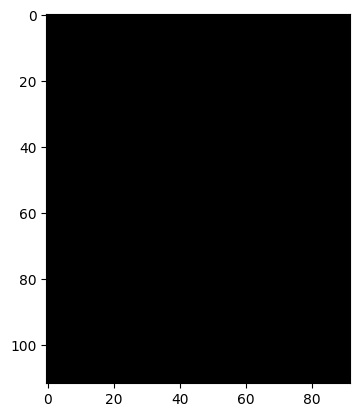

In [127]:
test_img = reshaped_train_set_decoded[:,:,3]
print(test_img.shape)
#convert to numpy
test_img = test_img.cpu().data.numpy()
#plot the first 1 images
plot_one_image(test_img)

Testset and Images Reconstruction

In [128]:
test_set, test_labels = eigenface.get_evaluate_set()
print(test_set.shape)
print(test_labels.shape)

L.shape = (10304, 160)
(10304, 160)
(160,)


In [129]:
# reshape the testset from  (10304, 160) to (10304*160,1)
test_set = test_set.reshape(-1,1) #put -1 for the unknown dimension 
print(test_set.shape)
print(test_labels.shape)
print(f"Before padding, test_set.shape = {test_set.shape}")
#

(1648640, 1)
(160,)
Before padding, test_set.shape = (1648640, 1)


In [130]:
#padding the test_set using all 0 to (2472960,1) #2472960 can be got from the shape of encoder_input
#print the size of encoder_input
print(torch.Tensor(eigenface.L).shape)
encoder_input = torch.Tensor(eigenface.L).reshape(-1,1)
print(encoder_input.shape)
#get the row from the shape
row, col = encoder_input.shape
print(row)
print(col)
# padding the test_set using all 0 to (row,1)
test_set = torch.Tensor(test_set)
# Pad test_set with zeros
if test_set.shape[0] < row:
    # Calculate the number of zeros needed for padding
    num_zeros = row - test_set.shape[0]
    
    # Create a tensor of zeros with the appropriate shape
    zeros = torch.zeros(num_zeros, 1)
    
    # Concatenate the zeros with test_set along the 0th dimension (rows)
    test_set_padded = torch.cat((test_set, zeros), dim=0)
else:
    test_set_padded = test_set

# Print the shape of the padded test_set
print(f"After padding: {test_set_padded.shape}")
print(test_set_padded[1648640:1648650])

torch.Size([10304, 240])
torch.Size([2472960, 1])
2472960
1
After padding: torch.Size([2472960, 1])
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])


In [131]:
import torch.nn.functional as F
#first, stem the padded test_set_padded into 3x3 using STEM function
test_set_stem = STEM(test_set_padded,3)
print(f"test_set_stem.shape = {test_set_stem.shape}")




X.shape = torch.Size([3, 3, 2472960, 1])
test_set_stem.shape = torch.Size([2472960, 1, 3, 3])


In [132]:
# using encoder_weight to encode the test_set_stem
encoder_weight = Encoder_output['W']
print(encoder_weight.shape)
print(test_set_stem.shape)
#reshape the test_set_stem to 2472960,9
test_set_stem = test_set_stem.reshape(-1, kernel*kernel)
print(test_set_stem.shape)
test_set_encoded = torch.matmul(test_set_stem, encoder_weight.t())
print(test_set_encoded.shape)


torch.Size([1, 9])
torch.Size([2472960, 1, 3, 3])
torch.Size([2472960, 9])
torch.Size([2472960, 1])


In [133]:
#STEM again to the test_set_encoded
test_set_decoder_input = STEM(test_set_encoded,3)
print(f"test_set_decoder_input.shape = {test_set_decoder_input.shape}")

X.shape = torch.Size([3, 3, 2472960, 1])
test_set_decoder_input.shape = torch.Size([2472960, 1, 3, 3])


In [134]:
#Use decoder_weight to decode the test_set_encoded
decoder_weight = weights_decoder
print(decoder_weight.shape)
print(test_set_decoder_input.shape)
#reshape the test_set_decoder_input to 2472960,9
test_set_decoder_input = test_set_decoder_input.reshape(-1, kernel*kernel)
print(test_set_decoder_input.shape)

torch.Size([9, 1])
torch.Size([2472960, 1, 3, 3])
torch.Size([2472960, 9])


In [135]:
test_set_decoded= torch.matmul(test_set_decoder_input, decoder_weight)
print(test_set_decoded.shape)

torch.Size([2472960, 1])


In [136]:
are_all_elements_zero = (test_set_decoded[1648640:] == 0.).all()
print(are_all_elements_zero)


tensor(False)


In [137]:
#remove the padding
test_set_decoded = test_set_decoded[:1648640]


In [138]:
print(test_set_decoded.shape)
#reshape to (10304, 160)
reshaped_test_set_decoded = test_set_decoded.reshape(112,92,160)
print(reshaped_test_set_decoded.shape)

torch.Size([1648640, 1])
torch.Size([112, 92, 160])


torch.Size([112, 92])


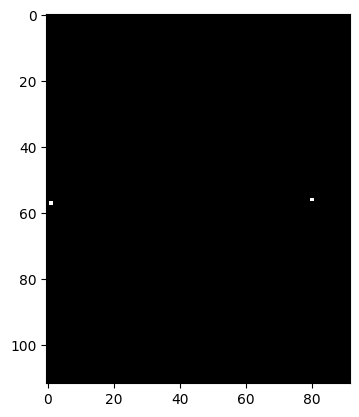

In [139]:
#get the first 1 images and convert to 2D numpy (112,92)
test_img = reshaped_test_set_decoded[:,:,0]
print(test_img.shape)
#convert to numpy
test_img = test_img.cpu().data.numpy()
#plot the first 1 images
plot_one_image(test_img)
# for i in range(10):
#     plot_one_image(reshaped_test_set_decoded[:,:,i])

In [148]:
def STEM(inputs, kernel = 3, channel = 1):
    m = kernel
    n = kernel
    if (m == n):
        X = []
        y, x = inputs.shape #(10304, 240)
        #print the size of torch.zeros...
        inputs_with_padding = torch.cat((inputs,torch.zeros((y,kernel))),-1)
        inputs_with_padding = torch.cat((inputs_with_padding,torch.zeros(kernel,x+kernel)),-2)
        for i in range(inputs.shape[0]):
            row = []
            for j in range(inputs.shape[1]):
                row.append(inputs_with_padding[i:i+kernel,j:j+kernel])
            X.append(row)
        X = torch.stack([torch.stack(x,2) for x in X],2).permute(0,1,2,3)
        print(f"X.shape = {X.shape}")
        
    # print(STEM.shape)
    stem_input = X.reshape(-1,1,kernel,kernel)
    return stem_input
def DPCA_eig(Y, X, m): #here we minimize $\| Y - F U X \|^2$
    # Y: (3,BHW), X: (27, BHW)
    print(f"Y.shape = {Y.shape}") # [1,2472960]
    print(f"X.shape = {X.shape}") # [9,2472960]
    n,p = X.size()
    print(f"n = {n}, p = {p}")
    XYt = torch.mm(X, Y.t())
    print(f"XYt.shape = {XYt.shape}") # [9,1]
    RM = torch.mm(torch.inverse(torch.mm(X, X.t())+1e-3*torch.eye(X.shape[0])),
			        torch.mm(XYt, XYt.t())) # [9,9]
    print(f"RM.shape = {RM.shape}")
    eigenvalues, eigenvectors = torch.linalg.eig(RM)
    
    values, indices = torch.sort(eigenvalues.real, descending=True)
    print(f"values.shape = {values.shape}")
    
    U = (eigenvectors[:, indices[:m]]).t().real  #(m,27)
    print(f"U.shape = {U.shape}")
    explained_variance = values[:m]
    UX = torch.mm(U,X)
    print(f"UX.shape = {UX.shape}")
    F = torch.mm(torch.mm(Y, UX.t()),
                 torch.inverse(torch.mm(UX, UX.t())+1e-3*torch.eye(UX.shape[0])),
			        )
    print(f"F.shape = {F.shape}")
    W = torch.mm(F, U)   #W = FU is a rank-m matrix
    print(f"W.shape = {W.shape}")

    return { 'X':X, 'k':m, 'components':U, 'explained_variance':explained_variance,
            'W': W}
def LSE(input, output):
  stem = input
  print(f"stem.shape = {stem.shape}") # [2472960, 1]
  targets = output.float() # [batch, 3, H, W] -> [batchxHxW, 3]
  print(f"targets.shape = {targets.shape}") #[2472960, 1]

  kernel_weights = torch.matmul(torch.inverse(torch.matmul(stem.t(),stem)+1e-3*torch.eye(stem.shape[-1])),
            torch.matmul(stem.t(), targets))
  return kernel_weights
def get_weights(images, n_components = 1, kernel = 3):
    images = torch.Tensor(images)
    encoder_input = STEM(images.reshape(-1,1), kernel) #X

    pca = PCA(n_components=n_components)
    encoder_input = encoder_input.reshape(-1, kernel*kernel)
    pca_result = pca.fit_transform(encoder_input)
    pca_result = torch.Tensor(pca_result) #Y

    encoder_weight = DPCA_eig(pca_result.t(),encoder_input.t(),n_components )['W'] #W

    decoder_input = STEM(pca_result.reshape(-1,1),kernel)
    decoder_input = decoder_input.reshape(-1, kernel*kernel)
    decoder_output = images.reshape(-1,1)
    decoder_weight = LSE(decoder_input, decoder_output) #supervised
    
    return torch.Tensor(encoder_weight), torch.Tensor(decoder_weight)

def encoder(encoder_input, encoder_weight, kernel = 3):
    encoder_input = torch.Tensor(encoder_input)
    input_stem = STEM(encoder_input.reshape(-1,1), kernel)
    encoder_output = torch.matmul(input_stem.reshape(-1, kernel*kernel), encoder_weight.t())
    return encoder_output
def decoder(decoder_input, decoder_weight,kernel = 3):
    decoder_input = torch.Tensor(decoder_input)
    input_stem = STEM(decoder_input.reshape(-1,1), kernel)
    decoder_output = torch.matmul(input_stem.reshape(-1, kernel*kernel), decoder_weight)
    return decoder_output



In [171]:
def plot_one_image(img):
    # plt.imshow('image window', img)
    # plt.imshow(img.cpu().data.numpy())
    img = (img - img.min()) / (img.max() - img.min()) * 255
    #print after normalization
    print(f"After normalizing: {img}")
    img = img.astype('uint8')
    plt.imshow(img, cmap='gray') 
    # plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

> Initializing started
L.shape = (10304, 240)
(10304, 240)
(10304,)
float64
original image: [[63. 53. 35. ... 36. 44. 45.]
 [56. 48. 31. ... 57. 50. 50.]
 [52. 29. 35. ... 54. 55. 61.]
 ...
 [35. 37. 36. ... 44.  9. 25.]
 [36. 35. 37. ... 40.  7. 28.]
 [35. 38. 34. ... 41. 10. 24.]]
After normalizing: [[70.42857143 58.28571429 36.42857143 ... 37.64285714 47.35714286
  48.57142857]
 [61.92857143 52.21428571 31.57142857 ... 63.14285714 54.64285714
  54.64285714]
 [57.07142857 29.14285714 36.42857143 ... 59.5        60.71428571
  68.        ]
 ...
 [36.42857143 38.85714286 37.64285714 ... 47.35714286  4.85714286
  24.28571429]
 [37.64285714 36.42857143 38.85714286 ... 42.5         2.42857143
  27.92857143]
 [36.42857143 40.07142857 35.21428571 ... 43.71428571  6.07142857
  23.07142857]]


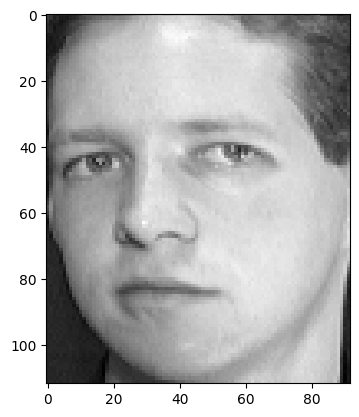

X.shape = torch.Size([3, 3, 10304, 1])
Y.shape = torch.Size([1, 10304])
X.shape = torch.Size([9, 10304])
n = 9, p = 10304
XYt.shape = torch.Size([9, 1])
RM.shape = torch.Size([9, 9])
values.shape = torch.Size([9])
U.shape = torch.Size([1, 9])
UX.shape = torch.Size([1, 10304])
F.shape = torch.Size([1, 1])
W.shape = torch.Size([1, 9])
X.shape = torch.Size([3, 3, 10304, 1])
stem.shape = torch.Size([10304, 9])
targets.shape = torch.Size([10304, 1])
torch.Size([1, 9])
torch.Size([9, 1])
X.shape = torch.Size([3, 3, 10304, 1])
encoder_output.shape: torch.Size([10304, 1])
encoder_output: tensor([[ 71.4153],
        [160.0025],
        [194.8625],
        ...,
        [  0.0000],
        [  0.0000],
        [  0.0000]])
After normalizing: [[ 41.448208  92.862755 113.094864 ... 177.58974  106.62003   70.401215]
 [ 57.47254  170.10246  203.47992  ... 210.00467  123.0398    76.13468 ]
 [125.37615  182.39677  207.78891  ... 214.57677  132.16476   81.635025]
 ...
 [  0.         0.         0.       .

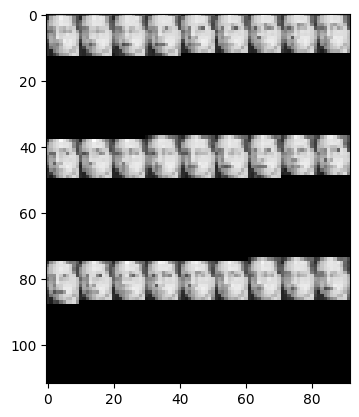

X.shape = torch.Size([3, 3, 10304, 1])
decoder_output.shape: (112, 92)
decoder_output: [[-0.68963546 -1.5946808  -0.9763558  ... -0.48196727 -2.4677565
  -1.1915765 ]
 [-1.4837995  -1.7005008   0.8817041  ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
After normalizing: [[123.35683   91.15654  113.1557   ... 130.74538   60.093697 105.49844 ]
 [ 95.10155   87.3916   179.26294  ... 147.89311  147.89311  147.89311 ]
 [147.89311  147.89311  147.89311  ... 147.89311  147.89311  147.89311 ]
 ...
 [147.89311  147.89311  147.89311  ... 147.89311  147.89311  147.89311 ]
 [147.89311  147.89311  147.89311  ... 147.89311  147.89311  147.89311 ]
 [147.89311  147.89311  147.89311  ... 147.89311  147.89311  147.89311 ]]

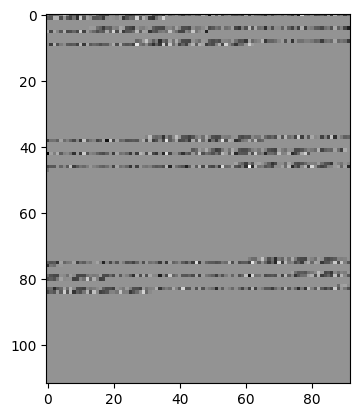

In [173]:
images = Eigenfaces(faces_dir_original).L
print(images.shape)
one_test_img = images[:,0]
print(one_test_img.shape)
#print date type of one_test_img, float32 or float64
print(one_test_img.dtype)
print(f"original image: {one_test_img.reshape(112,92)}")
#plot test image
plot_one_image(one_test_img.reshape(112,92)) #
# view_image(torch.Tensor(one_test_img).reshape(1,112,92))


encoder_weight, decoder_weight = get_weights(one_test_img, n_components = 1, kernel = 3)

print(encoder_weight.shape)
print(decoder_weight.shape)

encoder_output = encoder(one_test_img, encoder_weight, kernel = 3)
# print(f"encoder_output.shape: {encoder_output.shape}")
# print(f"encoder_output: {encoder_output}")
plot_one_image(encoder_output.reshape(112,92).cpu().data.numpy())


decoder_output = decoder(encoder_output, decoder_weight, kernel = 3)
# print(f"decoder_output: {decoder_output}")
# print(f"decoder_output.shape: {decoder_output.shape}")


#plot the restored image
img_out = decoder_output.reshape(112,92).cpu().data.numpy()
# print(f"decoder_output.shape: {img_out.shape}")
# print(f"decoder_output: {img_out}")

plot_one_image(img_out) #restored img

